# CISC 451/839 Topics in Data Analytics 
## Course Project - Using Feature Engineering and Supervised Learning to Predict Game Results in Professional Hockey 
### Gavin McClelland - 10211444 
### Marshall Cunningham - 20249991



The objectives of this notebook are as follows: 
- Explore the dataset provided on Kaggle, driven by the NHL's Real-Time Scoring System

## Contents

The analytics process contained in this notebook is as follows:

1. Explore event-driven data, such as shot locations
2. Simple EDA of player-level data
3. Basic EDA and model development for team-level data to serve as a benchmark for future work


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%cd "C:\Users\gmcclelland\Desktop\Misc School Stuff\repo\CISC451\project\data"
%matplotlib inline

C:\Users\gmcclelland\Desktop\Misc School Stuff\repo\CISC451\project\data


## Part 1: Simple EDA of Event-Driven Shot Data and Locations
Now that we have our datasets of interest for two NHL seasons, it is time to do some data exploration, let's start with individual events (where shots are of interest)

In [2]:
# let's get our selected datasets
plays = pd.read_csv('plays_2017-2018_2018-2019.csv')
games = pd.read_csv('games_2017-2018_2018-2019.csv')
skater_stats = pd.read_csv('skaterstats_2017-2018_2018-2019.csv')
team_stats = pd.read_csv('teamstats_2017-2018_2018-2019.csv')
s_info = pd.read_csv('player_info.csv') # static library of players
t_info = pd.read_csv('team_info.csv') # static library of teams

In [3]:
# simple view of plays dataset
plays.head()

,play_id,game_id,play_num,team_id_for,team_id_against,event,secondaryType,x,y,period,periodType,periodTime,periodTimeRemaining,dateTime,goals_away,goals_home,description,st_x,st_y,rink_side
0,2017030241_1,2017030241,1,NaN,NaN,Game Scheduled,NaN,NaN,NaN,1,REGULAR,0,1200,2018-04-26 23:34:04,0,0,Game Scheduled,NaN,NaN,NaN
1,2017030241_2,2017030241,2,NaN,NaN,Period Ready,NaN,NaN,NaN,1,REGULAR,0,1200,2018-04-27 02:09:49,0,0,Period Ready,NaN,NaN,NaN
2,2017030241_3,2017030241,3,NaN,NaN,Period Start,NaN,NaN,NaN,1,REGULAR,0,1200,2018-04-27 02:09:51,0,0,Period Start,NaN,NaN,NaN
3,2017030241_4,2017030241,4,28.0,54.0,Faceoff,NaN,0.0,0.0,1,REGULAR,0,1200,2018-04-27 02:10:02,0,0,Joe Pavelski faceoff won against Jonathan Marc...,0.0,0.0,NaN
4,2017030241_5,2017030241,5,54.0,28.0,Hit,NaN,-31.0,-36.0,1,REGULAR,16,1184,2018-04-27 02:10:37,0,0,Brayden McNabb hit Joonas Donskoi,31.0,36.0,NaN


In [4]:
# percentage of null values by column
plays.isna().sum()/len(plays)

play_id                0.000000
game_id                0.000000
play_num               0.000000
team_id_for            0.191090
team_id_against        0.191090
event                  0.000000
secondaryType          0.783132
x                      0.192796
y                      0.192790
period                 0.000000
periodType             0.000000
periodTime             0.000000
periodTimeRemaining    0.000000
dateTime               0.000000
goals_away             0.000000
goals_home             0.000000
description            0.000000
st_x                   0.192796
st_y                   0.192790
rink_side              0.224316
dtype: float64

In [5]:
# Different kinds of unique events
plays.event.unique()

array(['Game Scheduled', 'Period Ready', 'Period Start', 'Faceoff', 'Hit',
       'Shot', 'Stoppage', 'Penalty', 'Blocked Shot', 'Takeaway',
       'Giveaway', 'Missed Shot', 'Goal', 'Period End', 'Period Official',
       'Game End', 'Official Challenge', 'Game Official',
       'Shootout Complete', 'Early Intermission Start',
       'Early Intermission End', 'Emergency Goaltender'], dtype=object)

In [6]:
# so, there are many unique events that could be explored, let's look specifically at shots
shots = plays[(plays['event']=='Shot') | (plays['event']=='Missed Shot') | (plays['event']=='Blocked Shot')]
# while we're here, let's get all events that are goals too
goals = plays[plays['event']=='Goal']

In [7]:
# What are the different kinds of shots players take?
shots.secondaryType.unique()

array(['Wrist Shot', 'Deflected', nan, 'Slap Shot', 'Backhand',
       'Snap Shot', 'Wrap-around', 'Tip-In'], dtype=object)

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Wrist Shot'),
  Text(1, 0, 'Slap Shot'),
  Text(2, 0, 'Snap Shot'),
  Text(3, 0, 'Backhand'),
  Text(4, 0, 'Tip-In'),
  Text(5, 0, 'Deflected'),
  Text(6, 0, 'Wrap-around')])

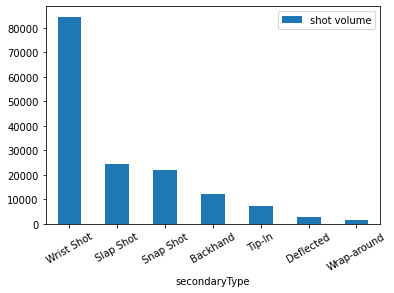

In [8]:
# let's look at the behaviour of each of these shot types based on volume of each shot type taken
s_volume = shots.groupby('secondaryType').size().to_frame('shot volume').sort_values(by='shot volume',ascending=False)
s_volume.plot(kind='bar')
plt.xticks(rotation=30)
#TODO: Plot needs more colour

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Wrist Shot'),
  Text(1, 0, 'Snap Shot'),
  Text(2, 0, 'Slap Shot'),
  Text(3, 0, 'Backhand'),
  Text(4, 0, 'Tip-In'),
  Text(5, 0, 'Deflected'),
  Text(6, 0, 'Wrap-around')])

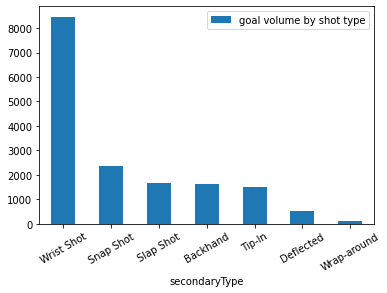

In [9]:
# Likewise, let's do the same with goals
g_volume = goals.groupby('secondaryType').size().to_frame('goal volume by shot type').sort_values(by='goal volume by shot type',ascending=False)
g_volume.plot(kind='bar')
plt.xticks(rotation=30)

Text(0.5, 1.0, 'Total Percent Conversion by Shot Type')

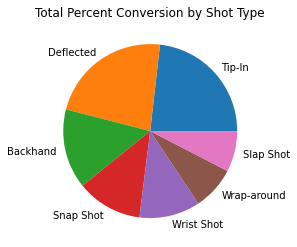

In [10]:
# next, let's get the conversion rate of each shot type as a %, meaning, on average, what is the percent chance that a shot of a certain type results in a goal, regardless of the location?

g_volume['shot volume'] = s_volume['shot volume']
g_volume['%conversion'] = round((g_volume['goal volume by shot type']/g_volume['shot volume'])*100,4) 
g_volume.sort_values(by='%conversion',ascending=False,inplace=True)
plt.pie(g_volume['%conversion'],labels=g_volume.index)
plt.title('Total Percent Conversion by Shot Type')

In [11]:
shots.isna().sum()/len(shots)

play_id                0.000000
game_id                0.000000
play_num               0.000000
team_id_for            0.000000
team_id_against        0.000000
event                  0.000000
secondaryType          0.480967
x                      0.000017
y                      0.000023
period                 0.000000
periodType             0.000000
periodTime             0.000000
periodTimeRemaining    0.000000
dateTime               0.000000
goals_away             0.000000
goals_home             0.000000
description            0.000000
st_x                   0.000017
st_y                   0.000023
rink_side              0.040218
dtype: float64

From the output above, note that roughly 48% of shots have a secondary type of NaN, and this is because they are either blocked or miss the net. It would be interesting to explore whether certain shots are more likely to miss the net or get blocked, but it appears as though this information is not available to us.

In [12]:
shots.loc[((shots.event == 'Blocked Shot') | (shots.event == 'Missed Shot')) & shots.secondaryType.notnull()]

,play_id,game_id,play_num,team_id_for,team_id_against,event,secondaryType,x,y,period,periodType,periodTime,periodTimeRemaining,dateTime,goals_away,goals_home,description,st_x,st_y,rink_side


In [13]:
print(f"Percentage of total shots that are blocked: {round((len(shots.loc[shots.event == 'Blocked Shot'])/len(shots)),4)*100}% \nPercentage of total shots that miss the net: {round((len(shots.loc[shots.event == 'Missed Shot'])/len(shots)),4)*100}%")
# f"Percentage of total shots that miss the net: {round((len(shots.loc[shots.event == 'Missed Shot'])/len(shots)),2)*100}%"

Percentage of total shots that are blocked: 26.25% 
Percentage of total shots that miss the net: 21.84%


While we're here, let's visualize the locations of blocked shots and shots that miss the net:

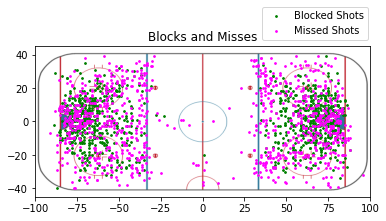

In [14]:
blocked = shots[shots['event']=='Blocked Shot']
blocked_sample = blocked.sample(n=1000, replace=False)
misses = shots[shots['event']=='Missed Shot']
misses_sample = misses.sample(n=1000, replace=False)
img = plt.imread("rink.png") # rink image taken from google
fig, ax = plt.subplots()
ax.imshow(img, extent=[-100, 100, -45, 45]) # re-sizing rink image to contain coordinates 
plt.scatter(blocked_sample['x'], blocked_sample['y'],s=3,label='Blocked Shots',color='green')
plt.scatter(misses_sample['x'], misses_sample['y'],s=3,label='Missed Shots',color='magenta')
plt.title('Blocks and Misses')
legend = ax.legend(loc='lower right',bbox_to_anchor= (1.01, 1.01))
plt.show()

Visualizing the locations of different shot attempts, and the shot attempt locations that result in a goal

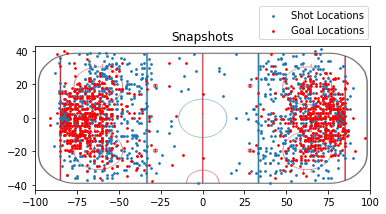

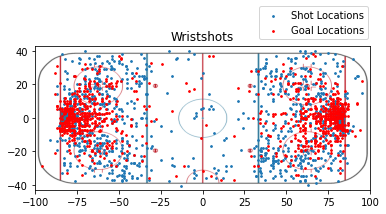

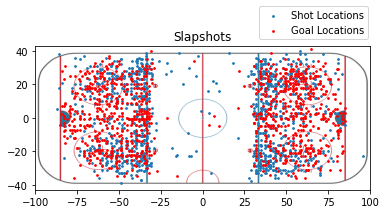

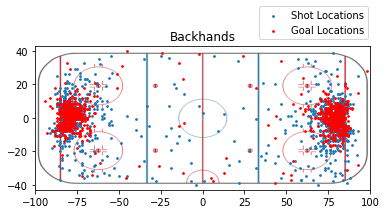

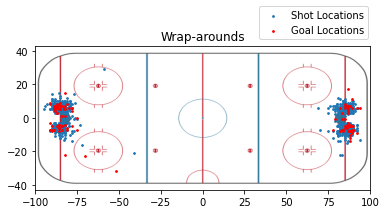

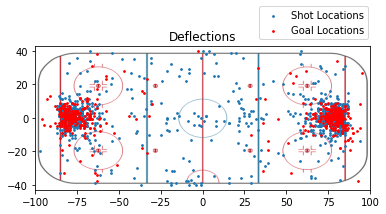

In [15]:
snapshots = shots[shots['secondaryType']=='Snap Shot']
snap_sample = snapshots.sample(n=1000, replace=False)
snap_goals = goals[goals['secondaryType']=='Snap Shot']
snap_goals_sample = snap_goals.sample(n=1000, replace=False)
img = plt.imread("rink.png")
fig, ax = plt.subplots()
ax.imshow(img, extent=[-100, 100, -43, 43])
plt.scatter(snap_sample['x'], snap_sample['y'],s=3,label='Shot Locations')
plt.scatter(snap_goals_sample['x'], snap_goals_sample['y'],s=3,color='red',label='Goal Locations')
plt.title('Snapshots')
legend = ax.legend(loc='lower right',bbox_to_anchor= (1.01, 1.01))
plt.show()

wrist = shots[shots['secondaryType']=='Wrist Shot']
wrist_sample = wrist.sample(n=1000, replace=False)
wrist_goals = goals[goals['secondaryType']=='Wrist Shot']
wrist_goals_sample = wrist_goals.sample(n=1000, replace=False)
img = plt.imread("rink.png")
fig, ax = plt.subplots()
ax.imshow(img, extent=[-100, 100, -43, 43])
plt.scatter(wrist_sample['x'], wrist_sample['y'],s=3,label='Shot Locations')
plt.scatter(wrist_goals_sample['x'], wrist_goals_sample['y'],s=3,color='red',label='Goal Locations')
plt.title('Wristshots')
legend = ax.legend(loc='lower right',bbox_to_anchor= (1.01, 1.01))
plt.show()

slap = shots[shots['secondaryType']=='Slap Shot']
slap_sample = slap.sample(n=1000, replace=False)
slap_goals = goals[goals['secondaryType']=='Slap Shot']
slap_goals_sample = slap_goals.sample(n=1000, replace=False)
img = plt.imread("rink.png")
fig, ax = plt.subplots()
ax.imshow(img, extent=[-100, 100, -43, 43])
plt.scatter(slap_sample['x'], slap_sample['y'],s=3,label='Shot Locations')
plt.scatter(slap_goals_sample['x'], slap_goals_sample['y'],s=3,color='red',label='Goal Locations')
plt.title('Slapshots')
legend = ax.legend(loc='lower right',bbox_to_anchor= (1.01, 1.01))
plt.show()

bh = shots[shots['secondaryType']=='Backhand']
bh_sample = bh.sample(n=1000, replace=False)
bh_goals = goals[goals['secondaryType']=='Backhand']
bh_goals_sample = bh_goals.sample(n=1000, replace=False)
img = plt.imread("rink.png")
fig, ax = plt.subplots()
ax.imshow(img, extent=[-100, 100, -43, 43])
plt.scatter(bh_sample['x'], bh_sample['y'],s=3,label='Shot Locations')
plt.scatter(bh_goals_sample['x'], bh_goals_sample['y'],s=3,color='red',label='Goal Locations')
plt.title('Backhands')
legend = ax.legend(loc='lower right',bbox_to_anchor= (1.01, 1.01))
plt.show()

wrap = shots[shots['secondaryType']=='Wrap-around']
wrap_sample = wrap.sample(n=1000, replace=False)
wrap_goals = goals[goals['secondaryType']=='Wrap-around']
img = plt.imread("rink.png")
fig, ax = plt.subplots()
ax.imshow(img, extent=[-100, 100, -43, 43])
plt.scatter(wrap_sample['x'], wrap_sample['y'],s=3,label='Shot Locations')
plt.scatter(wrap_goals['x'], wrap_goals['y'],s=3,color='red',label='Goal Locations')
plt.title('Wrap-arounds')
legend = ax.legend(loc='lower right',bbox_to_anchor= (1.01, 1.01))
plt.show()

deflections = shots[shots['secondaryType']=='Deflected']
def_sample = deflections.sample(n=1000, replace=False)
def_goals = goals[goals['secondaryType']=='Deflected']
img = plt.imread("rink.png")
fig, ax = plt.subplots()
ax.imshow(img, extent=[-100, 100, -43, 43])
plt.scatter(def_sample['x'], def_sample['y'],s=3,label='Shot Locations')
plt.scatter(def_goals['x'], def_goals['y'],s=3,color='red',label='Goal Locations')
plt.title('Deflections')
legend = ax.legend(loc='lower right',bbox_to_anchor= (1.01, 1.01))
plt.show()

That's a lot of events in just a few visuals, so let's breakdown what we can see here:

    - snapshots and wristshots can come from pretty much anywhere, and they are the most common

    - slapshots are typically taken from closer to the blueline, which we can see in the visual

    - backhands typically come from closer to the net, as they are weaker than others, as is the same with wrap-arounds (behind the net to the front), and deflections from shots that are taken from farther out (slapshots)

Further analysis will entail the use of these event-based shot data to support models at a higher-level of abstraction focused on predicting the outcome of a hockey match

## Part 2: Simple EDA of Player-Level Data
With event-level data already explored, the next layer of abstraction to explore is player-level information contained in the file 'skaterstats_2017-2018_2018-2019.csv', which contains player-level aggregate information by unique game_id 

### Surface-level Exploration
 Understanding what there is to work with at the player-level

In [16]:
s_info.head() # number of players in the library, s_info.shape = 2409 players in file

,player_id,firstName,lastName,nationality,birthCity,primaryPosition,birthDate,link
0,8467412,Alexei,Ponikarovsky,UKR,Kiev,LW,1980-04-09,/api/v1/people/8467412
1,8468501,Anton,Volchenkov,RUS,Moscow,D,1982-02-25,/api/v1/people/8468501
2,8459670,Kimmo,Timonen,FIN,Kuopio,D,1975-03-18,/api/v1/people/8459670
3,8471233,Travis,Zajac,CAN,Winnipeg,C,1985-05-13,/api/v1/people/8471233
4,8455710,Martin,Brodeur,CAN,Montreal,G,1972-05-06,/api/v1/people/8455710


In [17]:
skater_stats.head() # here we see that we can merge on player_id in the info table to get more metadata on each player (i.e. name), so let's do that:
skater_stats= pd.merge(skater_stats,s_info,on='player_id')
skater_stats.head()

,game_id,player_id,team_id,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,...,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce,firstName,lastName,nationality,birthCity,primaryPosition,birthDate,link
0,2017030241,8468542,28,601,0,0,0,1,0,0,...,529,60,12,Paul,Martin,USA,Minneapolis,D,1981-03-05,/api/v1/people/8468542
1,2017030242,8468542,28,638,0,0,1,1,0,0,...,638,0,0,Paul,Martin,USA,Minneapolis,D,1981-03-05,/api/v1/people/8468542
2,2017030243,8468542,28,935,0,0,0,3,0,0,...,888,47,0,Paul,Martin,USA,Minneapolis,D,1981-03-05,/api/v1/people/8468542
3,2017030181,8468542,28,947,0,0,1,0,0,0,...,908,39,0,Paul,Martin,USA,Minneapolis,D,1981-03-05,/api/v1/people/8468542
4,2017030182,8468542,28,995,0,0,1,1,0,0,...,995,0,0,Paul,Martin,USA,Minneapolis,D,1981-03-05,/api/v1/people/8468542


In [18]:
# Next, we can also introduce team-level info by joining on 'team_id' to get team-level metadata
skater_stats=pd.merge(skater_stats,t_info,on='team_id')

In [19]:
skater_stats.columns

Index(['game_id', 'player_id', 'team_id', 'timeOnIce', 'assists', 'goals',
       'shots', 'hits', 'powerPlayGoals', 'powerPlayAssists', 'penaltyMinutes',
       'faceOffWins', 'faceoffTaken', 'takeaways', 'giveaways',
       'shortHandedGoals', 'shortHandedAssists', 'blocked', 'plusMinus',
       'evenTimeOnIce', 'shortHandedTimeOnIce', 'powerPlayTimeOnIce',
       'firstName', 'lastName', 'nationality', 'birthCity', 'primaryPosition',
       'birthDate', 'link_x', 'franchiseId', 'shortName', 'teamName',
       'abbreviation', 'link_y'],
      dtype='object')

Above, we can see that the player-level stats contain aggregates of individual events on a game-by-game basis. This dataset also includes a breakdown of certain aggregates on special teams (powerPlay and shortHanded metrics)

- This is particularly useful moving forward because most of this data is numeric

In [20]:
skater_stats.describe()

,game_id,player_id,team_id,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,...,takeaways,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce,franchiseId
count,9.766700e+04,9.766700e+04,97667.000000,97667.000000,97667.000000,97667.000000,97667.000000,97667.000000,97667.000000,97667.000000,...,97667.00000,97667.000000,97667.000000,97667.000000,97667.000000,97667.000000,97667.000000,97667.000000,97667.000000,97667.000000
mean,2.017522e+09,8.475542e+06,19.069430,991.480992,0.275671,0.163894,1.759776,1.257262,0.033379,0.063624,...,0.41920,0.521343,0.004761,0.004833,0.811021,-0.009225,843.060870,65.766881,82.653240,22.531418
std,5.000178e+05,2.856850e+03,13.963456,282.648528,0.549999,0.421451,1.558404,1.428104,0.185954,0.263567,...,0.69901,0.803843,0.069576,0.069498,1.095014,1.169114,233.480569,81.416277,99.864139,9.940990
min,2.017020e+09,8.448208e+06,1.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,-6.000000,9.000000,0.000000,0.000000,1.000000
25%,2.017021e+09,8.474150e+06,8.000000,799.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,-1.000000,685.000000,0.000000,0.000000,15.000000
50%,2.018020e+09,8.476207e+06,17.000000,991.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,838.000000,35.000000,46.000000,23.000000
75%,2.018021e+09,8.477492e+06,25.000000,1182.500000,0.000000,0.000000,3.000000,2.000000,0.000000,0.000000,...,1.00000,1.000000,0.000000,0.000000,1.000000,1.000000,998.000000,111.000000,141.000000,31.000000
max,2.018030e+09,8.481486e+06,54.000000,2698.000000,5.000000,5.000000,13.000000,15.000000,3.000000,4.000000,...,8.00000,8.000000,2.000000,2.000000,11.000000,6.000000,2234.000000,723.000000,714.000000,38.000000


### Simple Metrics 
- From this dataset, which has been made more complete, simple but useful metrics can be created to perform analyses at both player and team-level
- Additionally, we can dig deeper to the individual events that make up these aggregates by joining (merging) on the 'game_id' column in the previously explored event-driven shot data, which presents some interesting opportunities moving forward

In [21]:
# Bearing in mind that we could drill-down to the individual game events as previously discussed, we can also aggregate to a higher level, and get totals grouping by players for the entire dataset
player_totals=skater_stats[['player_id','firstName','lastName','primaryPosition','timeOnIce', 'assists', 'goals','shots', 'hits', 'powerPlayGoals', 'powerPlayAssists', 'penaltyMinutes',
       'faceOffWins', 'faceoffTaken', 'takeaways', 'giveaways',
       'shortHandedGoals', 'shortHandedAssists', 'blocked', 'plusMinus',
       'evenTimeOnIce', 'shortHandedTimeOnIce', 'powerPlayTimeOnIce']]
player_totals = player_totals.groupby(['player_id','firstName','lastName','primaryPosition']).agg('sum')
player_totals = player_totals.sort_values(by='timeOnIce',ascending=False)
player_totals.head()

,,,,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,penaltyMinutes,faceOffWins,faceoffTaken,takeaways,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce
player_id,firstName,lastName,primaryPosition,,,,,,,,,,,,,,,,,,,
8470613,Brent,Burns,D,297316,137,36,721,240,14,49,92,0,1,178,274,1,5,306,-5,234632,21616,41068
8474590,John,Carlson,D,290171,130,33,525,151,11,70,80,0,1,145,220,0,0,367,32,216126,28794,45251
8474563,Drew,Doughty,D,267963,87,18,365,301,10,34,98,0,1,40,188,1,1,258,-11,211133,26194,30636
8475200,Dmitry,Orlov,D,264910,57,15,284,320,0,6,63,0,0,128,157,0,0,266,16,234330,18907,11673
8474565,Alex,Pietrangelo,D,263184,83,31,461,134,6,26,56,0,1,130,111,0,2,351,15,210549,22403,30232


In [22]:
# For a simple player-level metric, let's find the players with the best ratio of takeaways to giveaways, which is particularly useful when looking at concepts such as game flow
takeaway_leaders = player_totals[['takeaways','giveaways']]
takeaway_leaders['t_g_ratio']=takeaway_leaders['takeaways']/takeaway_leaders['giveaways']
takeaway_leaders = takeaway_leaders.replace(np.inf,np.nan).dropna()
takeaway_leaders = takeaway_leaders.sort_values(by='t_g_ratio',ascending=False)
takeaway_leaders.head(30)

,,,,takeaways,giveaways,t_g_ratio
player_id,firstName,lastName,primaryPosition,,,
8476955,Taylor,Leier,LW,11,1,11.000000
8477366,Luke,Johnson,C,6,1,6.000000
8478541,Markus,Hannikainen,LW,26,5,5.200000
8479580,Dylan,Gambrell,C,5,1,5.000000
8479315,Joey,Anderson,RW,12,3,4.000000
8478365,Danick,Martel,LW,4,1,4.000000
8477591,Josh,Jooris,RW,12,3,4.000000
8478462,Nicolas,Roy,C,4,1,4.000000
8478106,Dylan,Sikura,RW,26,7,3.714286


<AxesSubplot:title={'center':'Powerplay Goals by Team per Game (over the 2017-2018 and 2018-2019 Seasons'}, xlabel='abbreviation'>

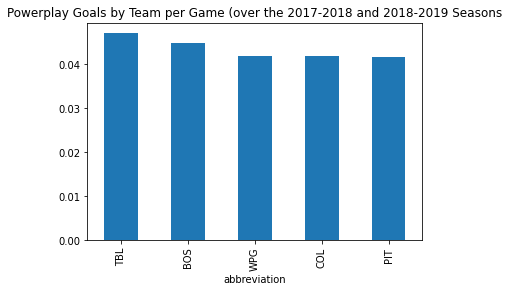

In [23]:
# To take things a step further, aggregates can be created at the team-level as a total/mean/etc of a column by all players belonging to one team
    # Moreover, aggregates can be created at the play-level as the total/mean/etc of a column over all plays in a game, or for all plays associated with a certain team in a game

# Let's use powerplay goals as an example
team_ppg=skater_stats.groupby(['abbreviation'])['powerPlayGoals'].agg('mean').nlargest(5)

team_ppg.sort_values(ascending=False).plot(kind='bar', title='Powerplay Goals by Team per Game (over the 2017-2018 and 2018-2019 Seasons')

## Part 3: Simple EDA of Team-Level Data
With event-level data already explored, the next layer of abstraction to explore is player-level information contained in the file 'teamstats_2017-2018_2018-2019.csv', which contains team-level aggregate information by unique game_id. Note that there are two records for each unique game_id, one for each team competing against each other 
- This short notebook serves to explore simple approaches similar to those existing to predict match outcome as a benchmark against which future models will be compared

In [24]:
team_stats = team_stats.merge(t_info,on='team_id') # merge with team metadata
team_stats.columns

Index(['game_id', 'team_id', 'HoA', 'won', 'settled_in', 'head_coach', 'goals',
       'shots', 'hits', 'pim', 'powerPlayOpportunities', 'powerPlayGoals',
       'faceOffWinPercentage', 'giveaways', 'takeaways', 'franchiseId',
       'shortName', 'teamName', 'abbreviation', 'link'],
      dtype='object')

Here we can clearly see the different categorical and numeric variables contained in each record. We want to use these to predict game outcome. For simplicity, let's consider a binary classification problem, where we only care about the 'won' column, and not whether or not the match was settled in regulation ('REG'), or overtime ('OT') 

In [25]:
team_stats.head()

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,franchiseId,shortName,teamName,abbreviation,link
0,2017030241,28,away,False,REG,Peter DeBoer,0,33,33,31,5,0,47.8,8,6,29,San Jose,Sharks,SJS,/api/v1/teams/28
1,2017030242,28,away,True,OT,Peter DeBoer,4,47,48,12,7,2,55.1,7,12,29,San Jose,Sharks,SJS,/api/v1/teams/28
2,2017030243,28,home,False,OT,Peter DeBoer,3,42,44,12,4,1,57.7,13,14,29,San Jose,Sharks,SJS,/api/v1/teams/28
3,2017030244,28,home,True,REG,Peter DeBoer,4,34,31,22,5,1,55.7,4,7,29,San Jose,Sharks,SJS,/api/v1/teams/28
4,2017030245,28,away,False,REG,Peter DeBoer,3,30,35,20,4,1,49.3,7,4,29,San Jose,Sharks,SJS,/api/v1/teams/28


Like player-level and event-driven data previously explored, this dataset could be explored in a similar fashion, but we are interested in better understanding the contributing factors to the match result. So, let's condense the existing dataset by selecting some features to construct a simple Logistic Regression model

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,plot_confusion_matrix,roc_curve,auc
team_stats['turnovers']=team_stats['takeaways']-team_stats['giveaways']
features = team_stats[['goals',
       'shots', 'hits', 'pim', 'powerPlayOpportunities', 'powerPlayGoals',
       'faceOffWinPercentage', 'turnovers']] # our features to train on
results = team_stats[['won']] # our target

x_train,x_test,y_train,y_test = train_test_split(features,results,test_size=0.3) # validate on 30% of dataset 
lr_clf = LogisticRegression()
lr_clf.fit(x_train,y_train)

LogisticRegression()

In [27]:
pred = lr_clf.predict(x_test)
accuracy_score(y_test,pred)

0.7862407862407862

In [28]:
# Let's create a confusion matrix for this model
confusion_matrix(y_test,pred)

array([[639, 174],
       [174, 641]], dtype=int64)

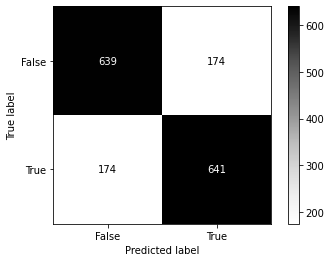

In [29]:
plot_confusion_matrix(lr_clf,x_test,y_test,cmap=plt.cm.Greys)

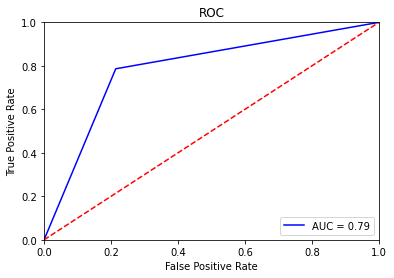

In [30]:
#TODO: Plot ROC - DONE
fpr, tpr, threshold = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
plt.title('ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

So, this simple Logistic Regression model performs really well, with an accuracy of over 77%! Why is this the case? GOALS and powerplay GOALS were included in the feature space! Common sense would dictate that knowing the number of goals a team scores would yield a good indication as to whether they would win the game or not. We want to predict the match outcome without this knowledge, because the only insight this provides is "If a team wants to win more games, they should simply score more goals". 

So, let's see what happens if we remove goals and powerplay goals from the feature space to assess the relationships between other team-level metrics and match result

In [31]:
better_features = team_stats[['shots', 'hits', 'pim', 'powerPlayOpportunities', 'faceOffWinPercentage', 'turnovers']] # our features to train on
results2 = team_stats[['won']] # our target

x_train2,x_test2,y_train2,y_test2 = train_test_split(better_features,results2,test_size=0.3) # validate on 30% of dataset 
lr_clf2 = LogisticRegression()
lr_clf2.fit(x_train2,y_train2)
pred2 = lr_clf2.predict(x_test2)
accuracy_score(y_test2,pred2)

0.5577395577395577

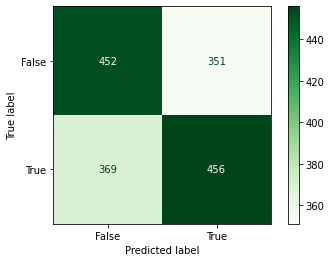

In [32]:
plot_confusion_matrix(lr_clf2,x_test2,y_test2,cmap=plt.cm.Greens)

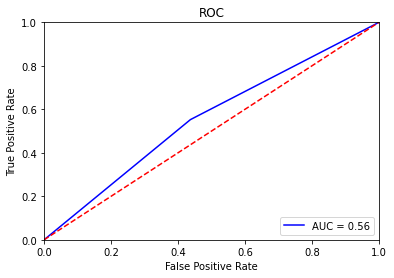

In [33]:
fpr2, tpr2, threshold2 = roc_curve(y_test2, pred2)
roc_auc2 = auc(fpr2, tpr2)
plt.title('ROC')
plt.plot(fpr2, tpr2, 'b', label = 'AUC = %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

This verifies the obvious assumption that goal-related information will have a great effect on the outcome of a match, and accuracy suffers when it's removed. This reinforces the motivating cause for this project, where even the best models are said to be not much better than 60% accurate, and this simple model is not much better than a coin flip (from the ROC curve)
- Moving forward, the objective is to create a denser feature space using the previously explored datasets (and potentially other sources mentioned in the proposal document) to create a more sophisticated model focused on improving this accuracy. 
- The objective is to predict the match outcome, so it would be prudent to include features that are available, and representative of each team before the game has started, which could synergize well with the events that take place over the course of the game to predict the outcome

In [36]:
team_stats.to_csv('teamstats_midterm.csv')